# Main Assignment Conditions

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

### Interconnect's services

Interconnect mainly provides two types of services:

1. Landline communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up via a telephone line (DSL, *digital subscriber line*) or through a fiber optic cable.

Some other services the company provides include:

- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

### Data Description

The data consists of files obtained from different sources:

- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.

import numpy as np
import pandas as pd
import sklearn

In [206]:
import pandas as pd
import numpy as np
import re
import sklearn
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import xgboost as XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')




In [207]:
#load dataframes and explore
df_contract = pd.read_csv('final_provider/contract.csv')
df_personal = pd.read_csv('final_provider/personal.csv')
df_internet = pd.read_csv('final_provider/internet.csv')
df_phone = pd.read_csv('final_provider/phone.csv')

In [208]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [209]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [210]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [211]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [212]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [213]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [214]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [215]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [216]:
#fix column names
df_contract.columns = [re.sub(r'(?<!^)(?<=[a-z])([A-Z])', r'_\1', col).lower()  for col in df_contract.columns]
df_personal.columns = [re.sub(r'(?<!^)(?<=[a-z])([A-Z])', r'_\1', col).lower()  for col in df_personal.columns]
df_internet.columns = [re.sub(r'(?<!^)(?<=[a-z])([A-Z])', r'_\1', col).lower()  for col in df_internet.columns]
df_phone.columns = [re.sub(r'(?<!^)(?<=[a-z])([A-Z])', r'_\1', col).lower()  for col in df_phone.columns]

df_contract eda

In [217]:
#fix total_charges to float
df_contract['total_charges'] = df_contract['total_charges'].apply(pd.to_numeric, errors='coerce')

In [218]:
#fix_ begin_date to datetime
df_contract['begin_date'] = df_contract['begin_date'].apply(pd.to_datetime, errors='coerce')

In [219]:
#create churn column off og the end_date column
df_contract['churn'] = df_contract['end_date'].apply(lambda x: 0 if x == 'No' else 1 )

In [220]:
#make 'No' valude in end_date = 'Nan'
df_contract['end_date'] = df_contract['end_date'].apply(lambda x: np.nan if x == 'No' else x )

In [221]:
#fix_ begin_date to datetime
df_contract['end_date'] = df_contract['end_date'].apply(pd.to_datetime, errors='coerce')

In [222]:
df_contract['payment_method'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [223]:
df_contract['paperless_billing'].unique()

array(['Yes', 'No'], dtype=object)

In [224]:
df_contract['type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [225]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   churn              7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


df_personal eda

In [226]:
df_personal.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [227]:
df_personal['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [228]:
df_personal['senior_citizen'].unique()

array([0, 1], dtype=int64)

In [229]:
df_personal['partner'].unique()

array(['Yes', 'No'], dtype=object)

In [230]:
df_personal['dependents'].unique()

array(['No', 'Yes'], dtype=object)

df_internet exploration

In [231]:
df_internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [232]:
df_internet['internet_service'].unique()

array(['DSL', 'Fiber optic'], dtype=object)

In [233]:
df_internet['online_security'].unique()

array(['No', 'Yes'], dtype=object)

In [234]:
df_internet['online_backup'].unique()

array(['Yes', 'No'], dtype=object)

df_phone eda

In [235]:
df_phone.head()

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [236]:
df_phone['multiple_lines'].unique()

array(['No', 'Yes'], dtype=object)

In [237]:
#fill in missing data with no for multiple lines
df_phone['multiple_lines'] = df_phone['multiple_lines'].fillna('No')

Join DFs Together - we will join all our dataframes into one

In [238]:
#merge df_contract and df_personal to new dataframe df_main with inner join
df_main = pd.merge(df_contract, df_personal, on='customer_id', how= 'inner' )

In [239]:
#outer join df_internet to df_main
df_main = pd.merge(df_main, df_internet, on='customer_id', how='outer')


In [240]:
#outer join df_phone to df_main
df_main = pd.merge(df_main, df_phone, on='customer_id', how='outer')

In [241]:
#drop rows where total_charges are missing. 
df_main = df_main.dropna(subset=['total_charges'])

In [242]:
#create a copy for Gradient Boosting
df_main_copy = df_main.copy()

OHE 

In [243]:
#perform OHE on relavant columns
df_main = pd.get_dummies(df_main, columns=['type','paperless_billing','payment_method' ,'gender','partner','dependents','internet_service','online_security','online_backup','device_protection','tech_support','streaming_tv','streaming_movies','multiple_lines'], drop_first=True )

Further EDA


churn
0    5163
1    1869
Name: count, dtype: int64


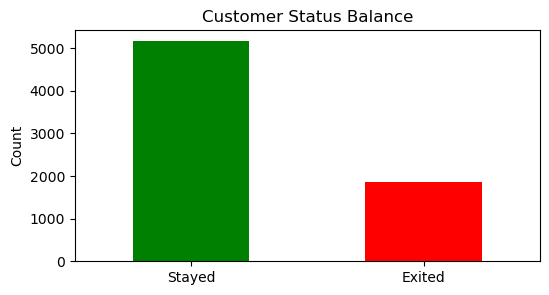

In [244]:
#explore class imbalance
exit_counts = df_main['churn'].value_counts()
print(exit_counts)

plt.figure(figsize=(6,3))
exit_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Customer Status Balance')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Stayed', 'Exited'], rotation=0)
plt.show()

Here we can see ther is a large inbalance between are too churn classes. We will need to take this into account before training our models.

Seasonality

In [245]:
# Filter the DataFrame to include only records where 'churn' is equal to 1
df_churn = df_main[df_main['churn'] == 1 ]


# Count occurrences of 'end_date' for churned customers and sort by index
churn_counts = df_churn['end_date'].value_counts().sort_index() 

# Resample the churn counts time series by month and sum the values
churn_counts_ts = churn_counts.resample('M').sum()

# Print the resampled time series
print(churn_counts_ts)

end_date
2019-10-31    458
2019-11-30    485
2019-12-31    466
2020-01-31    460
Freq: M, Name: count, dtype: int64


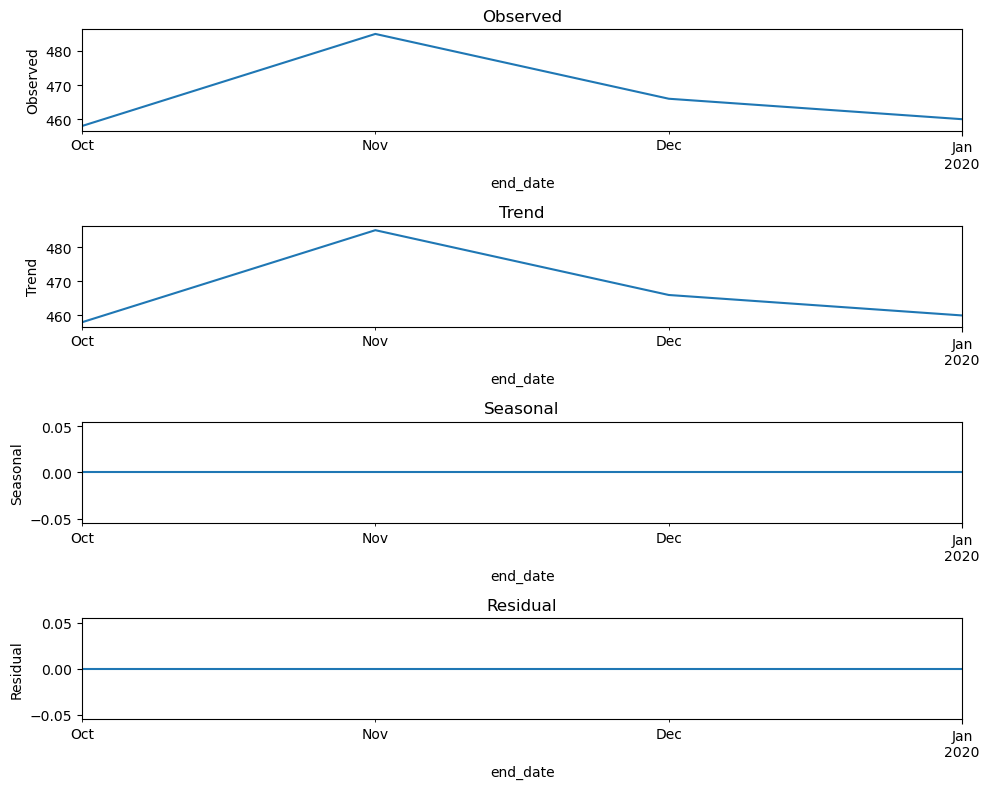

In [246]:

# Perform seasonal decomposition of the time series data
decomposition = seasonal_decompose(churn_counts_ts , model='additive', period=1)

# Create subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

# Plot the observed component
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
ax1.set_title('Observed')

# Plot the trend component
decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
ax2.set_title('Trend')

# Plot the seasonal component
decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
ax3.set_title('Seasonal')

# Plot the residual component
decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
ax4.set_title('Residual')

# Display 
plt.tight_layout()
plt.show()

No seasonality for our churn dates as they all are close in time to eachother. If we had more data over a longer period we would maybe be alble to see seasonality in our data.

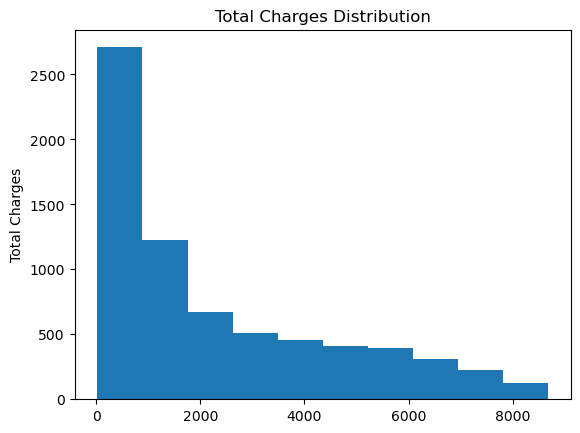

In [247]:
#explore charges distrobution
plt.hist(df_main['total_charges'].values)
plt.ylabel('Total Charges')
plt.title('Total Charges Distribution')
plt.show()

we can see here that our charges are scewed to the right. This indicates that we have a large number of customers paying a smaller amount and less customers paying higher rates.

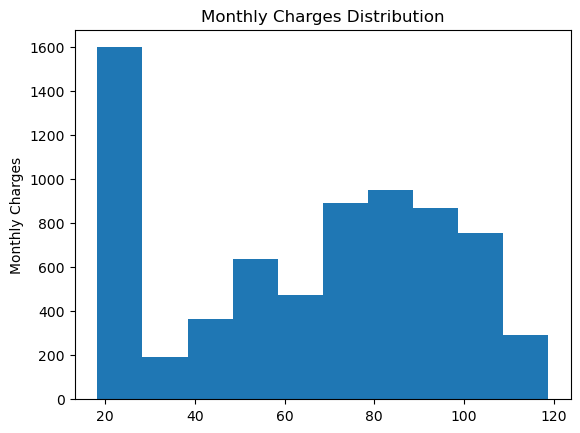

In [248]:
#explore monthly charges distribution
plt.hist(df_main['monthly_charges'].values)
plt.ylabel('Monthly Charges')
plt.title('Monthly Charges Distribution')
plt.show()

In this graph we can see there is a difference for monthly charges. We have a large amount of customers paying a small amount, and then a medium size amount of customers paying for higher prices

In [249]:
#create our features and target. We will drop end_date, begin_date, and customer_id
features = df_main.drop(['churn','end_date','begin_date', 'customer_id'], axis= 1)
target = df_main['churn']

Split Data Into Training, Validation, and Test Data

In [250]:
#split data for training and testing and validation
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345)

In [251]:
#look at our data set shapes
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(4218, 20)
(4218,)
(1407, 20)
(1407,)
(1407, 20)
(1407,)


Perform Scaling

In [252]:
# List of numeric columns to be scaled
numeric = ['monthly_charges','total_charges']

# Initialize a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training set and transform the numeric columns
scaler.fit(features_train[numeric])

# Apply the scaler transformation to the numeric columns in the training, test and validiation sets
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

Evaluation Function

In [253]:
#create function for evaluation
def print_evaluation(true, pred_binary, pred_prob, model_name):
    print(f"\n--- {model_name} ---")
  
    #calc and print f1 score
    f1_result = f1_score(true, pred_binary)
    print(f"F1 Score: {f1_result}")

    #calc and pring roc auc score
    auc = roc_auc_score(true, pred_prob)
    print(f"ROC AUC Score: {auc:.4f}")




Logistic Regressor Model with Unbalanced Data

In [254]:
#run the logisticregressor model before taking into account the imbalance of classes
LR_model = LogisticRegression(random_state=54321, solver='liblinear')

#fit the model
LR_model.fit(features_train, target_train)  

#get predictions on valid data
predictions= LR_model.predict(features_valid)

#get predictions probabilities
pred_prob = LR_model.predict_proba(features_valid)[:,1]

#evaluate the model
print_evaluation(target_valid, predictions, pred_prob, "Logistic Regression Unbalanced")





--- Logistic Regression Unbalanced ---
F1 Score: 0.5804511278195489
ROC AUC Score: 0.8406


Balanced Data Function

In [255]:

def balanced_sampling(features, target, downsample_frac=0.1, upsample_method='repeat', upsample_ratio=1, random_state=12345):
    # Determine majority and minority classes
    class_counts = target.value_counts()
    majority_class = class_counts.index[0]
    minority_class = class_counts.index[1]

    features_majority = features[target == majority_class]
    features_minority = features[target == minority_class]
    target_majority = target[target == majority_class]
    target_minority = target[target == minority_class]

    original_ratio = len(target_minority) / len(target)

    # Downsampling
    features_downsampled = pd.concat([
        features_majority.sample(frac=downsample_frac, random_state=random_state),
        features_minority
    ])
    target_downsampled = pd.concat([
        target_majority.sample(frac=downsample_frac, random_state=random_state),
        target_minority
    ])
    
    downsampled_ratio = sum(target_downsampled == minority_class) / len(target_downsampled)

    # Upsampling
    if upsample_method == 'repeat':
        repeat = int(upsample_ratio * len(features_majority) / len(features_minority))
        features_upsampled = pd.concat([features_majority] + [features_minority] * repeat)
        target_upsampled = pd.concat([target_majority] + [target_minority] * repeat)
    #elif upsample_method == 'smote':
    #    smote = SMOTE(sampling_strategy=upsample_ratio, random_state=random_state)
    #    features_upsampled, target_upsampled = smote.fit_resample(features, target)
    else:
        raise ValueError("Unsupported upsampling method. Use 'repeat' or 'smote'.")

    upsampled_ratio = sum(target_upsampled == minority_class) / len(target_upsampled)

    # Shuffling
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=random_state)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=random_state)

    return {
        'downsampled': (features_downsampled, target_downsampled),
        'upsampled': (features_upsampled, target_upsampled),
        'original_ratio': original_ratio,
        'downsampled_ratio': downsampled_ratio,
        'upsampled_ratio': upsampled_ratio
    }

In [256]:
#call balancing function
result = balanced_sampling(features_train, target_train, 
                           downsample_frac=0.35, 
                           upsample_method='repeat', 
                           upsample_ratio=1.2)


#unpack data to sets
features_downsampled, target_downsampled = result['downsampled']
features_upsampled, target_upsampled = result['upsampled']

#check data ratios
print(f"Original ratio: {result['original_ratio']:.2f}")
print(f"Downsampled ratio: {result['downsampled_ratio']:.2f}")
print(f"Upsampled ratio: {result['upsampled_ratio']:.2f}")

Original ratio: 0.26
Downsampled ratio: 0.50
Upsampled ratio: 0.52


Dummy Model

In [257]:
#create dummy model
dummy_most_frequent = DummyClassifier(strategy='most_frequent', random_state=12345)

#fit dummy model
dummy_most_frequent.fit(features_train, target_train)

#get predictions
y_pred_most_frequent = dummy_most_frequent.predict(features_valid)

#get predictions probabilities
pred_prob = dummy_most_frequent.predict_proba(features_valid)[:,1]

#evaluate the model
print_evaluation(target_valid, y_pred_most_frequent, pred_prob, "Dummy Most Frequent")




--- Dummy Most Frequent ---
F1 Score: 0.0
ROC AUC Score: 0.5000


Logistic Regression on Downsampled Data

In [258]:

#Test Logistic Regression Model with the downsampled data
LR_model = LogisticRegression(random_state=54321, solver='liblinear', class_weight='balanced' )

#fit LR model
LR_model.fit(features_downsampled, target_downsampled)  

#get predictions
predictions= LR_model.predict(features_valid)

#get prediction probabilities
pred_prob = LR_model.predict_proba(features_valid)[:,1]

#evaluate the model
print_evaluation(target_valid, predictions, pred_prob, "Logistic Regression Down Samples")



--- Logistic Regression Down Samples ---
F1 Score: 0.6323529411764706
ROC AUC Score: 0.8400


Logistic Regression on Upsampled Data

In [259]:
#Test Logistic Regression Model with the upsampled data
LR_model = LogisticRegression(random_state=54321, solver='liblinear', class_weight='balanced' )

#fit LR model
LR_model.fit(features_upsampled, target_upsampled)  

#get predictions
predictions= LR_model.predict(features_valid)

#get predictions probabilities
pred_prob = LR_model.predict_proba(features_valid)[:,1]

#evaluate the model
print_evaluation(target_valid, predictions, pred_prob, "Logistic Regression Up Samples")



--- Logistic Regression Up Samples ---
F1 Score: 0.6310272536687631
ROC AUC Score: 0.8399


Random Forest Classifier on Downsampled Data

In [260]:
# Initialize variable to store the best ROC AUC score found
rf_best_roc_auc_result = 0

# Iterate over a range of values for the number of estimators (trees)
for est in range(1, 50):
    # Iterate over a range of values for the maximum depth of the trees
    for depth in range(1,50):
        # Initialize a RandomForestClassifier with the current values of n_estimators and max_depth
        model1 = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')

        # Train the model using the downsampled dataset
        model1.fit(features_downsampled, target_downsampled)

         # Make predictions on the validation set
        predictions = model1.predict(features_valid)

        #pred probabilities
        pred_prob = LR_model.predict_proba(features_valid)[:,1]

         # Calculate the ROC AUC score for the current model
        roc_auc_result = roc_auc_score(target_valid, pred_prob)
        
         # Check if the current ROC AUC score is better than the best one found so far
        if roc_auc_result  > rf_best_roc_auc_result:
            # If it is, update the best model and the corresponding parameters
            best_RF_model_upsampled = model1          
            best_depth = depth
            best_est = est
            rf_best_roc_auc_result = roc_auc_result
            rf_best_prob = pred_prob
            predictions_bestmodel = predictions 

# Print the evaluation of the best model found, including its parameters
print_evaluation(target_valid, predictions_bestmodel, rf_best_prob, f"Random Forest Down Sampled (max depth: {best_depth}, n_estimators: {best_est} )")








--- Random Forest Down Sampled (max depth: 1, n_estimators: 1 ) ---
F1 Score: 0.37185929648241206
ROC AUC Score: 0.8399


Random Forest Classifier on Upsampled Data

In [261]:
# Initialize variable to store the best ROC AUC score found
rf_best_roc_auc_result = 0

# Iterate over a range of values for the number of estimators (trees)

for est in range(1,50):
    # Iterate over a range of values for the maximum depth of the trees
    for depth in range(1,50):

         # Initialize a RandomForestClassifier with the current values of n_estimators and max_depth
        model2 = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')

        # Train the model using the upsampled dataset
        model2.fit(features_upsampled, target_upsampled)

        # Make predictions on the validation set
        predictions = model2.predict(features_valid)

        #pred probabilities
        pred_prob = LR_model.predict_proba(features_valid)[:,1]

        # Calculate the ROC AUC score for the current model
        roc_auc_result = roc_auc_score(target_valid, predictions)
        
        # Check if the current ROC AUC score is better than the best one found so far
        if roc_auc_result  > rf_best_roc_auc_result:
            # If it is, update the best model and the corresponding parameters
            best_RF_model_downsampled = model2          
            best_depth = depth
            best_est = est
            rf_best_roc_auc_result = roc_auc_result
            rf_best_prob = pred_prob
            predictions_bestmodel = predictions 

# Print the evaluation of the best model found, including its parameters
print_evaluation(target_valid, predictions_bestmodel, rf_best_prob, f"Random Forest Upsampled (max depth: {best_depth}, n_estimators: {best_est} )")


--- Random Forest Upsampled (max depth: 8, n_estimators: 26 ) ---
F1 Score: 0.6538461538461539
ROC AUC Score: 0.8399


LightGBM

In [262]:
#create features and target data for gradient boosting datasets
features_lgb = df_main_copy.drop(['churn','end_date','begin_date', 'customer_id'], axis= 1)
target_lgb = df_main_copy['churn']

In [264]:
# List of categorical features in the dataset
cats = ["type","paperless_billing","payment_method","gender","senior_citizen","partner","dependents","internet_service","online_security","online_backup","device_protection","tech_support","streaming_tv","streaming_movies", "multiple_lines"]

# Iterate over each categorical feature
for col in cats:
    # Convert the column data type to 'category' for LightGBM
    # This helps LightGBM recognize and handle categorical features appropriately
    features_lgb[col] = features_lgb[col].astype('category')


In [265]:
#split data into datasets for training
features_train_lgb, features_test_lgb, target_train_lgb, target_test_lgb = train_test_split(
    features_lgb, target_lgb, test_size=0.2, random_state=12345)

features_train_lgb, features_valid_lgb, target_train_lgb, target_valid_lgb = train_test_split(
    features_train_lgb, target_train_lgb, test_size=0.25, random_state=12345)

In [282]:
# Create LightGBM dataset
train_data = lgb.Dataset(features_train_lgb, label=target_train_lgb, categorical_feature=cats)
valid_data = lgb.Dataset(features_valid_lgb, label=target_valid_lgb, reference=train_data, categorical_feature= cats)
test_data = lgb.Dataset(features_test_lgb, label=target_test_lgb, reference=train_data, categorical_feature= cats)


# Define LightGBM parameters
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    'metric': 'auc',  
    "num_leaves": 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train the model
lgbm = lgb.train(params, train_data, num_boost_round=100, valid_sets=[train_data, valid_data], callbacks=[lgb.early_stopping(stopping_rounds=10)])

#pred probablities
lgbm_prob = lgbm.predict(features_valid_lgb, num_iteration=lgbm.best_iteration)

#get binary predictions
lgbm_pred_binary = [1 if x > 0.5 else 0 for x in lgbm_prob]

#Print Evaluation
print_evaluation(target_valid_lgb, lgbm_pred_binary, lgbm_prob, "LightGBM")

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	training's auc: 0.902778	valid_1's auc: 0.852376

--- LightGBM ---
F1 Score: 0.6071428571428571
ROC AUC Score: 0.8524


XGB Classifier

In [280]:
# Initialize a LabelEncoder object
label_encoder = LabelEncoder()

#create features and target data for gradient boosting datasets
features_xgb = df_main_copy.drop(['churn','end_date','begin_date', 'customer_id'], axis= 1)
target_xgb = df_main_copy['churn']


# Dictionary to store label encoders for each categorical feature
label_encoders = {}

# Iterate over each categorical feature
for col in cats:
    # Initialize a new LabelEncoder for the column
    le = LabelEncoder()
    # Fit the LabelEncoder and transform the categorical values to numeric values
    features_xgb[col] = le.fit_transform(features_xgb[col])
    # Store the LabelEncoder in the dictionary
    label_encoders[col] = le

# Split the data
features_train_xgb, features_test_xgb, target_train_xgb, target_test_xgb = train_test_split(
    features_xgb, target_xgb, test_size=0.2, random_state=12345)

features_train_xgb, features_valid_xgb, target_train_xgb, target_valid_xgb = train_test_split(
    features_train_xgb, target_train_xgb, test_size=0.25, random_state=12345)

In [268]:
# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb_model.fit(features_train_xgb, target_train_xgb)  #, eval_set=[(features_valid_lgb, target_valid_lgb)], early_stopping_rounds=10, verbose=True)

#Pred prob
xgb_prob = xgb_model.predict_proba(features_valid_xgb)[:, 1]


# Make predictions
xgb_pred = xgb_model.predict(features_valid_xgb)

#Print Evaluation
print_evaluation(target_valid_xgb, xgb_pred, xgb_prob, "XGB Classifier")



--- XGB Classifier ---
F1 Score: 0.563953488372093
ROC AUC Score: 0.8235


Analyze the results of all our model training.

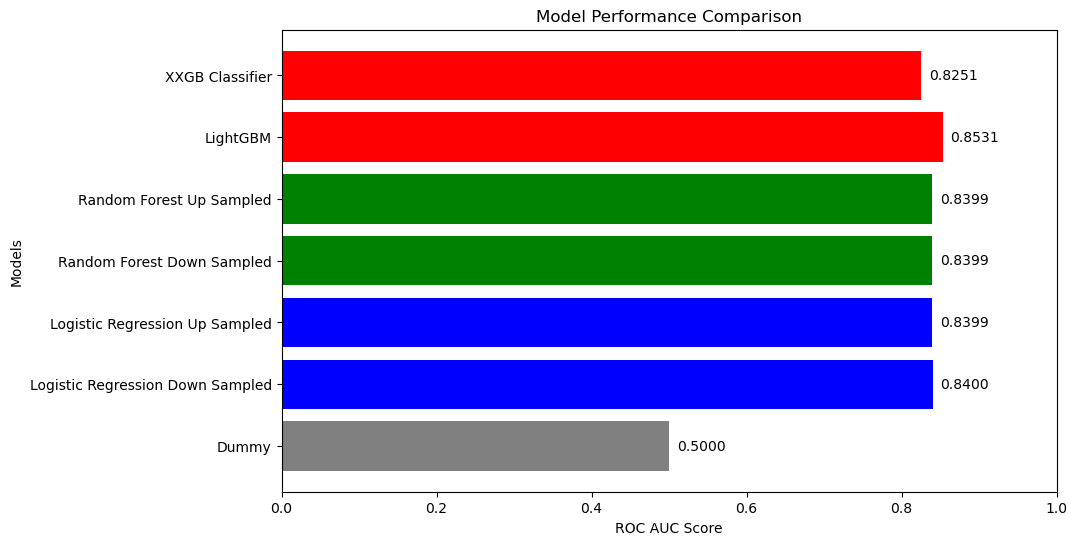

In [272]:
#create array of models
models = [
    "Dummy",
    "Logistic Regression Down Sampled",
    "Logistic Regression Up Sampled",
    "Random Forest Down Sampled",
    "Random Forest Up Sampled",
    "LightGBM",
    "XGB Classifier"
]
scores = [0.5, 0.8400, 0.8399, 0.8399, 00.8399, 0.8531, 0.8251]

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(models, scores, color=['gray', 'blue', 'blue', 'green', 'green', 'red', 'red'])

# Add labels and title
plt.xlabel('ROC AUC Score')
plt.ylabel('Models')
plt.title('Model Performance Comparison')

# Add the score values on the bars
for bar, score in zip(bars, scores):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{score:.4f}', 
             va='center', ha='left', color='black')

# Customize the plot (optional)
plt.xlim(0, 1)  # Set the x-axis limit from 0 to 1

# Display the chart
plt.show()

FINAL MODEL: LightGBM

In [270]:
# Create LightGBM dataset
train_data = lgb.Dataset(features_train_lgb, label=target_train_lgb, categorical_feature=cats)
valid_data = lgb.Dataset(features_valid_lgb, label=target_valid_lgb, reference=train_data, categorical_feature= cats)
test_data = lgb.Dataset(features_test_lgb, label=target_test_lgb, reference=train_data, categorical_feature= cats)


# Define LightGBM parameters
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    'metric': 'auc',  
    "num_leaves": 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train the model
final_model = lgb.train(params, train_data, num_boost_round=100, valid_sets=[train_data, valid_data], callbacks=[lgb.early_stopping(stopping_rounds=10)])

#creal final prob predictions
final_prob = final_model.predict(features_test_lgb, num_iteration=final_model.best_iteration)


#get binary predictions
final_pred_binary = [1 if x > 0.5 else 0 for x in final_prob]

#Print Evaluation
print_evaluation(target_test_lgb, final_pred_binary, final_prob, "Final Model LightGBM")


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	training's auc: 0.902778	valid_1's auc: 0.852376

--- Final Model LightGBM ---
F1 Score: 0.5850746268656717
ROC AUC Score: 0.8449


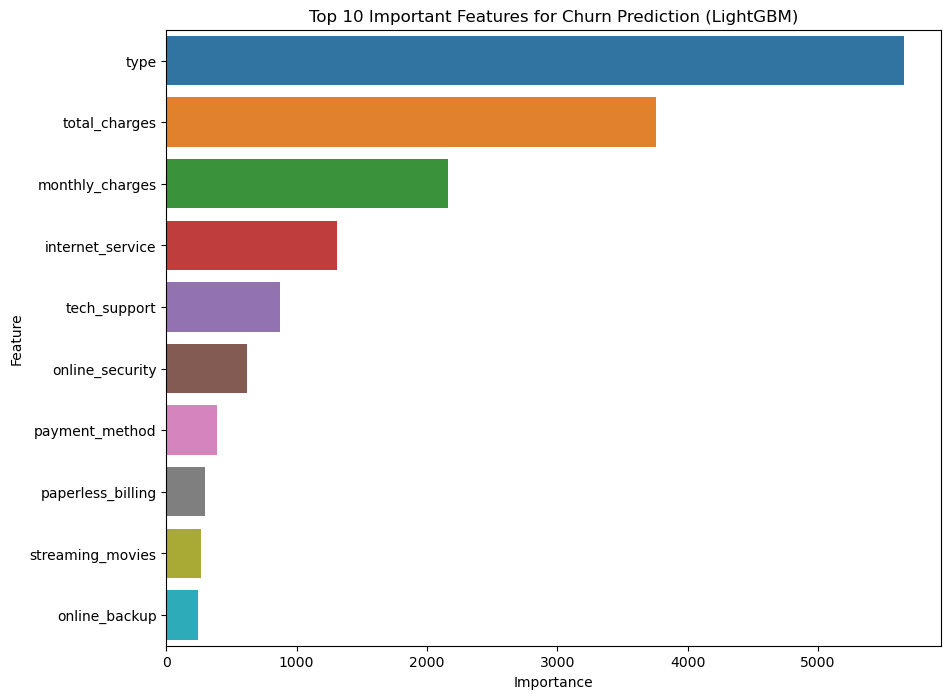

In [204]:
# Extract feature importances
feature_importances = pd.DataFrame({
    'feature': features_test_lgb.columns,
    'importance': final_model.feature_importance(importance_type='gain')
})

# Sort feature importances by descending order
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Visualize the top features
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(10))
plt.title('Top 10 Important Features for Churn Prediction (LightGBM)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Conclusion

After assessing our four model types and training them on our data, we found that the Light Gradient Boosting Model (LightGBM) achieved the highest ROC-AUC score of 0.8531. On our final testing dataset, the model delivered a score of 0.8431.

In analyzing the model's results, we discovered that the type of plan our customers had was the most significant factor influencing their decision to cancel the service. This was followed by their monthly charges and total charges. Based on these insights, I recommend further exploring the correlation between the type of plan and the associated charges. It is possible that higher prices for certain plans are prompting customers to switch to another carrier. By lowering prices or offering additional services to these customers, we might be able to improve retention.